# Residual Networks Transfer Learning

Loading a pre-trained ResNet model, removing the last layer and train with small data set.

Based on Coursera Deep Learning class

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
#import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
import glob

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


### Load training and testing data

In [14]:
def evaluate_model(model, X_train, Y_train, X_test, Y_test, maxItem = 100):
    #test model on training data set and testing data set
    nTrain = min([maxItem, X_train.shape[0]])
    print('Performance on Training data set')
    preds = model.evaluate(X_train[0:nTrain], Y_train[0:nTrain])
    print ("Loss = " + str(preds[0]))
    print ("Train Accuracy = " + str(preds[1]))

    nTest = min([maxItem, X_test.shape[0]])
    print('Performance on Testing data set')
    preds = model.evaluate(X_test[0:nTest], Y_test[0:nTest])
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


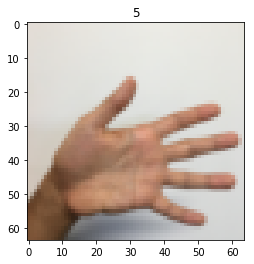

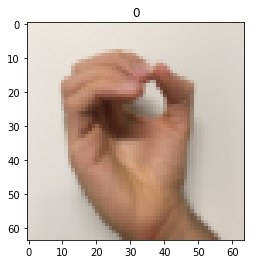

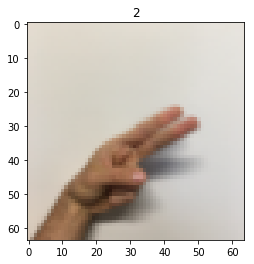

In [3]:
for i in range(3):
    plt.figure()
    plt.imshow(X_train[i])
    plt.title(str(np.argmax(Y_train[i])))

### Load pre-trained model

In [5]:
model = load_model('ResNet50.h5') 

In [6]:
evaluate_model(model, X_train, Y_train, X_test, Y_test)

Performance on Training data set
100/100 [==============================] - 2s 25ms/step
Loss = 0.176317252889
Test Accuracy = 0.98
Performance on Testing data set
120/120 [==============================] - 2s 20ms/step
Loss = 0.255691120028
Test Accuracy = 0.91666667064


This pre-trained ResNet model has high accuracy in both training and testing dataset

## remove last dense layer, and add our new dense layer

In [7]:
for layer in model.layers:
    layer.trainable = False

In [8]:
model.layers.pop()

In [9]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')

In [10]:
X = Dense(6, activation='softmax', name='final_dense_layer_for_handgesture', kernel_initializer = glorot_uniform(seed=10))(model.layers[-1].output)

In [11]:
myResNet = Model(input = model.input, output = X)

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fi...)`
  """Entry point for launching an IPython kernel.


In [12]:
myResNet.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [20]:
myResNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [16]:
evaluate_model(myResNet, X_train, Y_train, X_test, Y_test)

Performance on Training data set
100/100 [==============================] - 2s 24ms/step
Loss = 3.22376895905
Train Accuracy = 0.19
Performance on Testing data set
100/100 [==============================] - 2s 20ms/step
Loss = 3.0397632122
Test Accuracy = 0.19


### Note:
This new myResNet model's final layer was randomly initilized. Hence it has a bad performance on both training and testing data set

In [17]:
myResNet.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 23s 21ms/step - loss: 0.5993 - acc: 0.8407
Epoch 2/2
1080/1080 [==============================] - 22s 20ms/step - loss: 0.0792 - acc: 0.9843


In [18]:
evaluate_model(myResNet, X_train, Y_train, X_test, Y_test)

Performance on Training data set
100/100 [==============================] - 2s 20ms/step
Loss = 0.198618771434
Train Accuracy = 0.99
Performance on Testing data set
100/100 [==============================] - 2s 22ms/step
Loss = 0.343534240723
Test Accuracy = 0.93


### Comments:
1. Training on the last layer, which only has about 12,000 parameters, takes 20 second on CPU laptop. This is reduced from about 3 minutes if it was to train on the entire model

2. After only two epochs, the accuracy increased from 0.19 to 0.99 on training dataset and 0.93 on testing dataset
3. Note that what I did here isn't really transfer learning. This is because the original ResNet model was training on the same training data set.

## Load new dataset (Caltech 101 Object class)
We will now create a new Resnet model with last layer reset. We will load new dataset ('beaver','pyramid','llama','lotus','crab','car_side') from the 101 Caltech object class dataset, and choose 70% of them for training and 30% of them for testing 

In [22]:
selected_classes = ['beaver','pyramid','llama','lotus','crab','car_side']
folderpath = './../imageRecognition/Caltech101_Dataset/101_ObjectCategories/'

In [23]:
def loading_new_dataset(train_pct = 0.8,  classes = selected_classes):
    
    images_data = []
    labels = []
    
    for iclass,class_name in enumerate(classes):
        this_folder = folderpath + class_name
        sub_images = glob.glob(this_folder + '/*')
        for image_path in sub_images:
            print('reading %s with label %s' % (image_path, classes[iclass]))
            img = image.load_img(image_path, target_size=(64, 64))
            x = image.img_to_array(img)
            images_data.append(x)
            labels.append(iclass)
    
    images_data = np.array(images_data)
    labels = np.array(labels)
    
    m = images_data.shape[0]
    permuted_index = np.random.permutation(m)
    split_m = int(np.ceil(m*train_pct))

    train_ind = list(permuted_index[0:split_m])
    test_ind = list(permuted_index[split_m:])

    x_train, y_train = images_data[train_ind], labels[train_ind]
    x_test,  y_test  = images_data[test_ind],  labels[test_ind]
    
    return x_train, y_train, x_test, y_test

In [25]:
x_train_new,y_train_new,x_test_new,y_test_new = loading_new_dataset(classes = selected_classes)

x_train_new = x_train_new/255.
x_test_new = x_test_new/255.

# Convert training and test labels to one hot matrices
y_train_new = convert_to_one_hot(y_train_new, len(selected_classes)).T
y_test_new = convert_to_one_hot(y_test_new, len(selected_classes)).T


reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0012.jpg with label beaver
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0034.jpg with label beaver
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0013.jpg with label beaver
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0014.jpg with label beaver
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0015.jpg with label beaver
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0016.jpg with label beaver
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0017.jpg with label beaver
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0018.jpg with label beaver
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/beaver/image_0019.jpg with label beaver
reading ./

reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0019.jpg with label llama
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0020.jpg with label llama
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0021.jpg with label llama
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0022.jpg with label llama
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0023.jpg with label llama
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0024.jpg with label llama
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0025.jpg with label llama
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0026.jpg with label llama
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/llama/image_0027.jpg with label llama
reading ./../imageRecognitio

reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0055.jpg with label lotus
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0056.jpg with label lotus
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0057.jpg with label lotus
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0058.jpg with label lotus
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0059.jpg with label lotus
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0060.jpg with label lotus
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0061.jpg with label lotus
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0062.jpg with label lotus
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/lotus/image_0063.jpg with label lotus
reading ./../imageRecognitio

reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_0082.jpg with label car_side
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_0083.jpg with label car_side
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_0084.jpg with label car_side
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_0085.jpg with label car_side
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_0086.jpg with label car_side
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_0087.jpg with label car_side
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_0088.jpg with label car_side
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_0089.jpg with label car_side
reading ./../imageRecognition/Caltech101_Dataset/101_ObjectCategories/car_side/image_009

In [28]:
print ("number of training examples = " + str(x_train_new.shape[0]))
print ("number of test examples = " + str(x_test_new.shape[0]))
print ("X_train shape: " + str(x_train_new.shape))
print ("Y_train shape: " + str(y_train_new.shape))
print ("X_test shape: " + str(x_test_new.shape))
print ("Y_test shape: " + str(y_test_new.shape))

number of training examples = 355
number of test examples = 88
X_train shape: (355, 64, 64, 3)
Y_train shape: (355, 6)
X_test shape: (88, 64, 64, 3)
Y_test shape: (88, 6)


/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


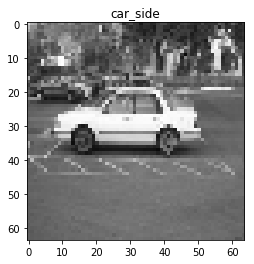

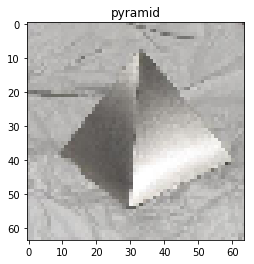

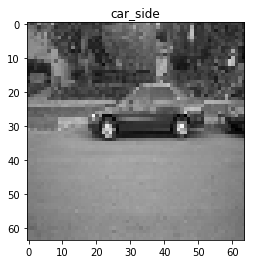

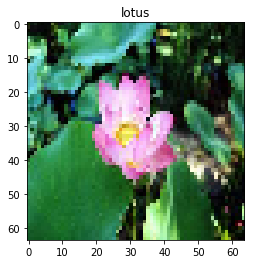

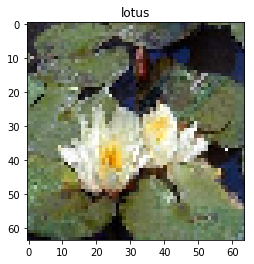

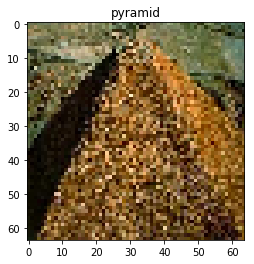

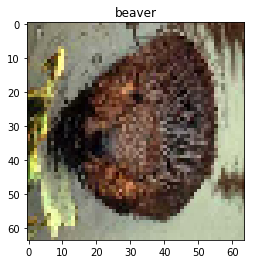

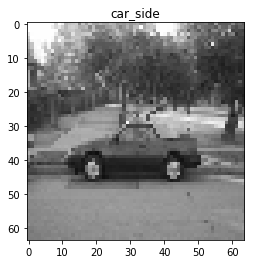

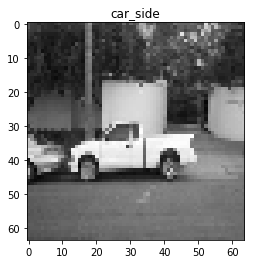

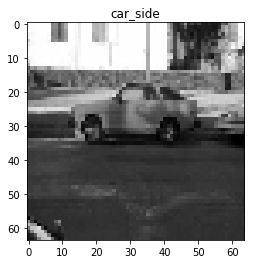

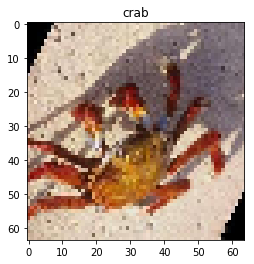

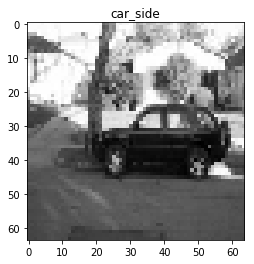

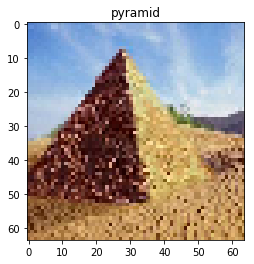

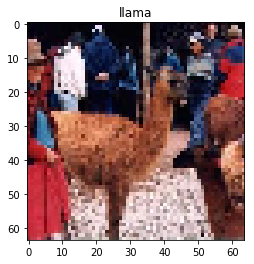

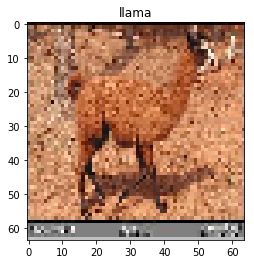

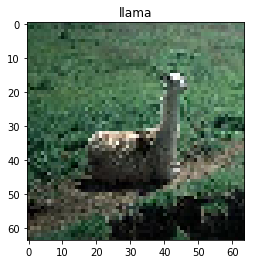

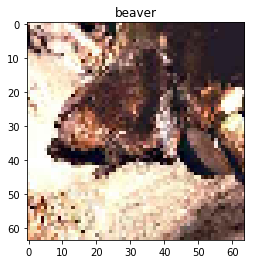

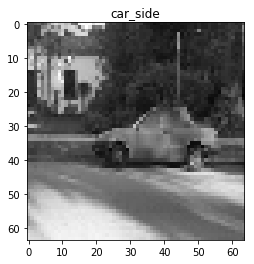

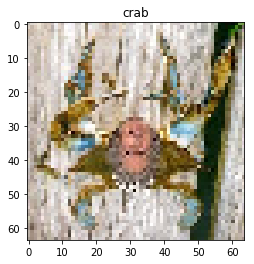

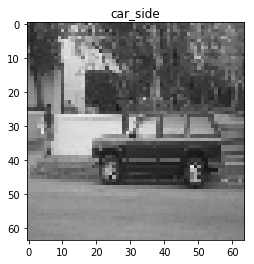

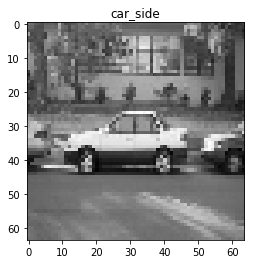

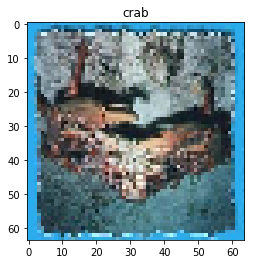

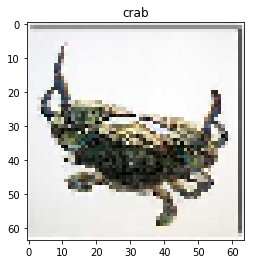

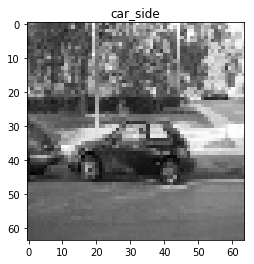

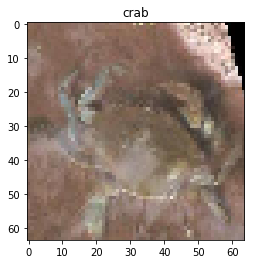

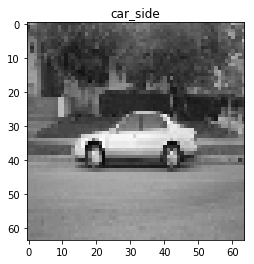

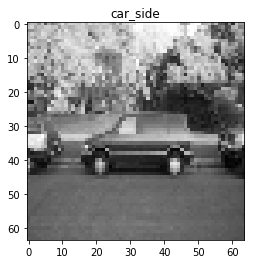

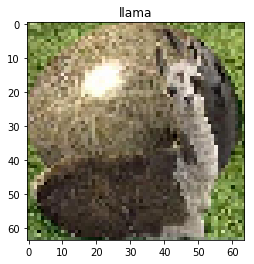

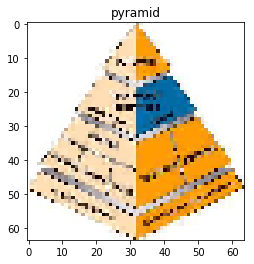

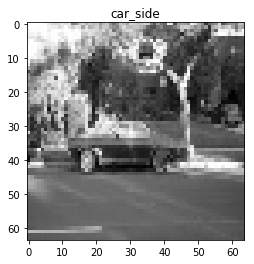

In [30]:
for i in range(5):
    plt.figure()
    plt.imshow(x_train_new[i])
    plt.title(selected_classes[np.argmax(y_train_new[i])])

In [59]:
X = Dense(len(selected_classes), activation='softmax', name='final_dense_layer_for_recognition', kernel_initializer = glorot_uniform(seed=0))(model.layers[-1].output)
my_NewResNet = Model(input = model.input, output = X)
my_NewResNet.layers[-6].trainable = True
my_NewResNet.layers[-7].trainable = True
my_NewResNet.layers[-9].trainable = True
my_NewResNet.layers[-10].trainable = True
my_NewResNet.layers[-12].trainable = True
my_NewResNet.layers[-13].trainable = True
my_NewResNet.layers[-16].trainable = True
my_NewResNet.layers[-17].trainable = True


my_NewResNet.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
my_NewResNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fi...)`
  


In [60]:
evaluate_model(my_NewResNet, x_train_new, y_train_new, x_test_new, y_test_new)

Performance on Training data set
100/100 [==============================] - 3s 29ms/step
Loss = 2.26608402252
Train Accuracy = 0.48
Performance on Testing data set
88/88 [==============================] - 2s 23ms/step
Loss = 2.97004437447
Test Accuracy = 0.420454548164


In [61]:
my_NewResNet.fit(x_train_new, y_train_new, epochs = 25, batch_size = 32)

Epoch 1/25
355/355 [==============================] - 10s 29ms/step - loss: 1.6611 - acc: 0.6113
Epoch 2/25
355/355 [==============================] - 9s 26ms/step - loss: 1.7074 - acc: 0.6197
Epoch 3/25
355/355 [==============================] - 9s 26ms/step - loss: 1.4061 - acc: 0.6789
Epoch 4/25
355/355 [==============================] - 9s 26ms/step - loss: 1.7044 - acc: 0.6197
Epoch 5/25
355/355 [==============================] - 9s 26ms/step - loss: 1.3698 - acc: 0.6592
Epoch 6/25
355/355 [==============================] - 10s 27ms/step - loss: 1.5251 - acc: 0.6620
Epoch 7/25
355/355 [==============================] - 10s 27ms/step - loss: 1.4315 - acc: 0.6845
Epoch 8/25
355/355 [==============================] - 10s 27ms/step - loss: 1.4256 - acc: 0.6648
Epoch 9/25
355/355 [==============================] - 10s 27ms/step - loss: 1.4023 - acc: 0.7211
Epoch 10/25
355/355 [==============================] - 10s 27ms/step - loss: 1.6896 - acc: 0.6592
Epoch 11/25
355/355 [============

In [62]:
evaluate_model(my_NewResNet, x_train_new, y_train_new, x_test_new, y_test_new)

Performance on Training data set
100/100 [==============================] - 2s 20ms/step
Loss = 1.38817584991
Train Accuracy = 0.72
Performance on Testing data set
88/88 [==============================] - 2s 20ms/step
Loss = 2.97494753924
Test Accuracy = 0.443181820891


In [65]:
prediction_result = my_NewResNet.predict(x_train_new)
predicted_labels = np.argmax(prediction_result,axis=1)

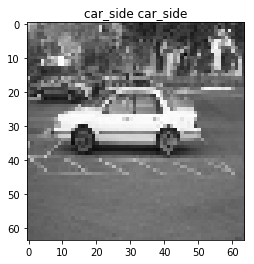

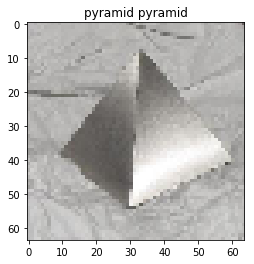

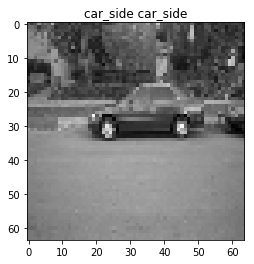

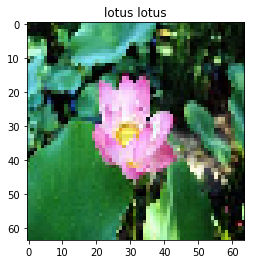

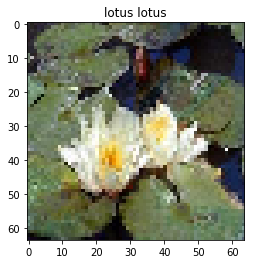

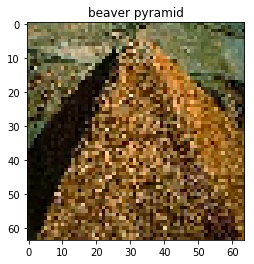

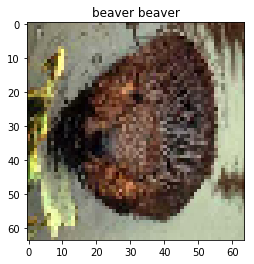

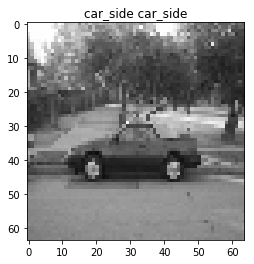

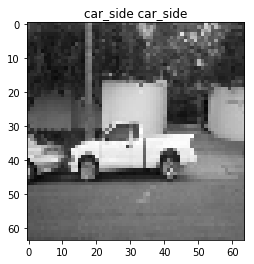

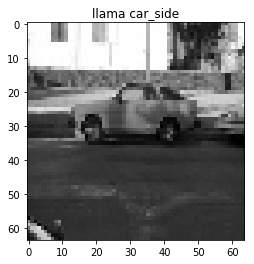

In [66]:
for i in range(10):
    actu = np.argmax(y_train_new[i])
    plt.figure()
    plt.imshow(x_train_new[i])
    plt.title(selected_classes[predicted_labels[i]] + ' ' + selected_classes[actu])
    

In [ ]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

You can also print a summary of your model by running the following code.

In [ ]:
model.summary()

Finally, run the code below to visualize your ResNet50. You can also download a .png picture of your model by going to "File -> Open...-> model.png".

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))